## Preamble

In [1]:
# Load packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/intermediate/call_reports_wrds/'

# set path as working directory:
os.chdir(path)

In [3]:
# Load legacy data
rcfd_legacy = pd.read_csv(path+'/legacy/RCFD_legacy.csv')
#rcfn_legacy = pd.read_csv(path+'/legacy/RCFN_legacy.csv')
rcon_legacy = pd.read_csv(path+'/legacy/RCON_legacy.csv')
riad_legacy = pd.read_csv(path+'/legacy/RIAD_legacy.csv')

In [4]:
rcfd_legacy.rename(columns={'RSSD9999':'Date', 'RSSD9010': 'Financial Institution Name', 
                     'RSSD9001': 'IDRSSD'}, inplace=True)

riad_legacy.rename(columns={'RSSD9999':'Date', 'RSSD9010': 'Financial Institution Name', 
                     'RSSD9001': 'IDRSSD'}, inplace=True)

rcon_legacy.rename(columns={'RSSD9999':'Date', 'RSSD9010': 'Financial Institution Name', 
                     'RSSD9001': 'IDRSSD'}, inplace=True)

In [5]:
rcfd_legacy['Date'] = pd.to_datetime(rcfd_legacy['Date'], format='%Y%m%d')
riad_legacy['Date'] = pd.to_datetime(riad_legacy['Date'], format='%Y%m%d')
rcon_legacy['Date'] = pd.to_datetime(rcon_legacy['Date'], format='%Y%m%d')

In [6]:
# Load newer data
rcfd = pd.read_csv(path+'/newer/RCFD.csv')
rcfa = pd.read_csv(path+'/newer/RCFA.csv')
rcfn = pd.read_csv(path+'/newer/RCFN.csv')
rcon = pd.read_csv(path+'/newer/RCON.csv')
riad = pd.read_csv(path+'/newer/RIAD.csv')

In [7]:
# Rename column RSSD9999 to Date:
rcfd.rename(columns={'RSSD9999':'Date', 'RSSD9017': 'Financial Institution Name', 
                     'RSSD9001': 'IDRSSD'}, inplace=True)

rcfa.rename(columns={'RSSD9999':'Date', 'RSSD9017': 'Financial Institution Name', 
                     'RSSD9001': 'IDRSSD'}, inplace=True)

rcfn.rename(columns={'RSSD9999':'Date', 'RSSD9017': 'Financial Institution Name', 
                     'RSSD9001': 'IDRSSD'}, inplace=True)

rcon.rename(columns={'RSSD9999':'Date', 'RSSD9017': 'Financial Institution Name', 
                     'RSSD9001': 'IDRSSD'}, inplace=True)

riad.rename(columns={'RSSD9999':'Date', 'RSSD9017': 'Financial Institution Name', 
                     'RSSD9001': 'IDRSSD'}, inplace=True)

In [8]:
riad['Date'] = pd.to_datetime(riad['Date'], format='%Y-%m-%d')
rcfd['Date'] = pd.to_datetime(rcfd['Date'], format='%Y-%m-%d')
rcfa['Date'] = pd.to_datetime(rcfa['Date'], format='%Y-%m-%d')
rcfn['Date'] = pd.to_datetime(rcfn['Date'], format='%Y-%m-%d')
rcon['Date'] = pd.to_datetime(rcon['Date'], format='%Y-%m-%d')

In [9]:
# put NaN instead of zeros in rcon and rcon_legacy:
rcon['RCON2122'] = rcon['RCON2122'].replace(0, np.nan)
rcon_legacy['RCON2122'] = rcon_legacy['RCON2122'].replace(0, np.nan)

## Merging Loans

In [10]:
# show me the dates in rcon_legacy where 'RCON2122' and 'RCON1400' are not NaN:
df_rcon = pd.merge(rcon_legacy[['Date', 'IDRSSD', 'RCON2122', 'RCON1400']], 
                     rcon[['Date', 'Financial Institution Name', 'IDRSSD', 'RCON2122']],
                        on=['Date', 'IDRSSD'], suffixes=('_legacy', '_new'), how='outer')
# take the difference between RCON2122_new and RCON2122_legacy:
df_rcon['Difference'] = df_rcon['RCON2122_new'] - df_rcon['RCON2122_legacy']

# exclude the last date:
df_rcon = df_rcon[df_rcon['Date']<df_rcon['Date'].max()]

Note that even for the Dates that _legacy_ and _newer_ RCON series coincide, we have a discrepancies between the those two.  

In [11]:
df_rcon = df_rcon[['Date', 'IDRSSD', 'Financial Institution Name', 'RCON2122_legacy', 'RCON2122_new', 'Difference']]

# create a 'Flag' colum that takes the value zero if the difference is zero:
df_rcon['Flag'] = np.where(df_rcon['Difference'] == 0, 0, 1)

# let flag to be zero in places where either RCON2122_legacy or RCON2122_new is NaN:
df_rcon['Flag'] = np.where(df_rcon['RCON2122_legacy'].isna() | df_rcon['RCON2122_new'].isna(), 0, df_rcon['Flag'])

In [12]:
df_rcon['RCON2122'] = df_rcon['RCON2122_new'].fillna(df_rcon['RCON2122_legacy'])

In [13]:
# exclude observations made in moments different than quarter ends:
df_rcon = df_rcon[df_rcon['Date'].dt.month.isin([3, 6, 9, 12])]

#date_min = df_rcon.groupby('Date')['RCON2122'].sum()==df_rcon.groupby('Date')['RCON2122'].sum().min()
#df_rcon[df_rcon['Date'].isin(date_min[date_min].index)]

In [14]:
# Step 1: Identify the total number of unique dates
total_dates = df_rcon['Date'].nunique()

# Step 2: Count the number of unique dates per bank
bank_date_counts = df_rcon.groupby('IDRSSD')['Date'].nunique()

# Step 3: Filter banks with observations for all dates
balanced_banks = bank_date_counts[bank_date_counts == total_dates].index

# Step 4: Save the list of IDRSSD
balanced_banks_list = balanced_banks.tolist()

In [15]:
# drop observations from the last 'Date':
balanced_rcon = df_rcon[df_rcon['IDRSSD'].isin(balanced_banks_list)]

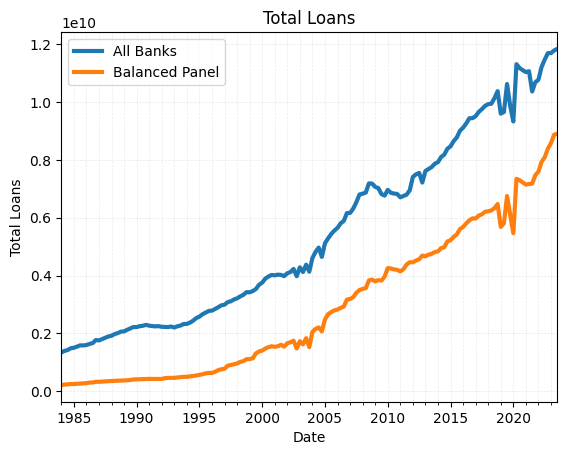

In [16]:
# sum 'Loans' by 'Date' and plot the time series:
df_rcon[df_rcon['Flag']==0].groupby('Date')['RCON2122'].sum().plot(linewidth=3)
balanced_rcon[balanced_rcon['Flag']==0].groupby('Date')['RCON2122'].sum().plot(linewidth=3)
plt.title('Total Loans')
plt.xlabel('Date')
plt.ylabel('Total Loans')
plt.legend(['All Banks', 'Balanced Panel'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5, color='lightgrey')
plt.show()

In [17]:
# export the balanced panel to a csv file:
balanced_rcon.to_csv(path+'/loans_balanced_panel.csv', index=False)
df_rcon.to_csv(path+'/loans_unbalanced.csv', index=False)

## Merging Interest Rate Income

In [18]:
# show me the dates in rcon_legacy where 'RCON2122' and 'RCON1400' are not NaN:
df_riad = pd.merge(riad_legacy[['Date', 'IDRSSD', 'RIAD4010', 'RIAD4065']], 
                     riad[['Date', 'IDRSSD', 'Financial Institution Name', 'RIAD4010', 'RIAD4065']],
                        on=['Date', 'IDRSSD'], suffixes=('_legacy', '_new'), how='outer')

df_riad['Difference 4010'] = df_riad['RIAD4010_new'] - df_riad['RIAD4010_legacy']
df_riad['Difference 4065'] = df_riad['RIAD4065_new'] - df_riad['RIAD4065_legacy']

# exclude the last date:
df_riad = df_riad[df_riad['Date']<df_riad['Date'].max()]

In [19]:
df_riad = df_riad[['Date', 'IDRSSD', 'Financial Institution Name', 'RIAD4010_legacy', 'RIAD4010_new',
                    'RIAD4065_legacy', 'RIAD4065_new', 'Difference 4010', 'Difference 4065']]

# create a 'Flag' colum that takes the value zero if the difference is zero:
df_riad['Flag'] = np.where((df_riad['Difference 4010'] == 0) & (df_riad['Difference 4065']==0), 0, 1)

# let flag to be zero in places where either RCON2122_legacy or RCON2122_new is NaN:
df_riad['Flag'] = np.where(df_riad['Difference 4010'].isna() | df_riad['Difference 4065'].isna(), 0, df_riad['Flag'])

In [20]:
df_riad['Aux'] = (df_riad['RIAD4010_new']+
                                df_riad['RIAD4065_new']).fillna(df_riad['RIAD4010_legacy']+df_riad['RIAD4065_legacy'])

df_riad['Int. Income Loans'] = df_riad.groupby(['IDRSSD', df_riad['Date'].dt.year])['Aux'].diff().fillna(df_riad['Aux'])

In [21]:
df_riad = df_riad[['Date', 'IDRSSD', 'Financial Institution Name', 'Int. Income Loans', 'Flag']]

In [22]:
# exclude observations made in moments different than quarter ends:
df_riad = df_riad[df_riad['Date'].dt.month.isin([3, 6, 9, 12])]

In [23]:
# Step 1: Identify the total number of unique dates
total_dates = df_riad['Date'].nunique()

# Step 2: Count the number of unique dates per bank
bank_date_counts = df_riad.groupby('IDRSSD')['Date'].nunique()

# Step 3: Filter banks with observations for all dates
balanced_banks = bank_date_counts[bank_date_counts == total_dates].index

# Step 4: Save the list of IDRSSD
balanced_banks_list = balanced_banks.tolist()

# drop observations from the last 'Date':
balanced_riad = df_riad[df_riad['IDRSSD'].isin(balanced_banks_list)]

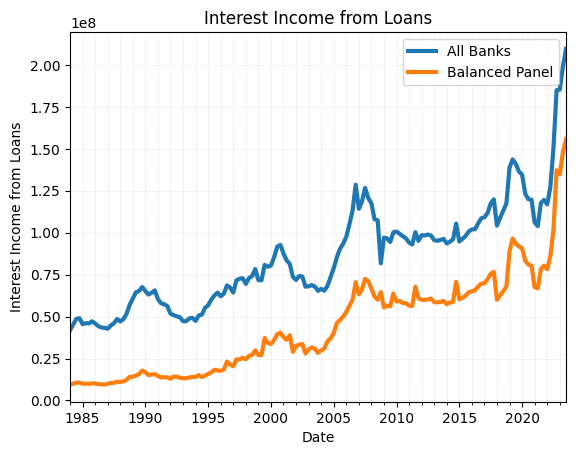

In [24]:
df_riad[df_riad['Flag']==0].groupby('Date')['Int. Income Loans'].sum().plot(linewidth=3)
balanced_riad[balanced_riad['Flag']==0].groupby('Date')['Int. Income Loans'].sum().plot(linewidth=3)
plt.title('Interest Income from Loans')
plt.xlabel('Date')
plt.ylabel('Interest Income from Loans')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5, color='lightgrey')
plt.legend(['All Banks', 'Balanced Panel'])
plt.show()

In [25]:
# export the balanced panel to a csv file:
balanced_riad.to_csv(path+'/interest_income_balanced.csv', index=False)
df_riad.to_csv(path+'/interest_income_unbalanced.csv', index=False)

## Merging Assets

In [26]:
# show me the dates in rcon_legacy where 'RCON2122' and 'RCON1400' are not NaN:
df_rcon = pd.merge(rcon_legacy[['Date', 'IDRSSD', 'RCON2170']], 
                     rcon[['Date', 'Financial Institution Name', 'IDRSSD', 'RCON2170']],
                        on=['Date', 'IDRSSD'], suffixes=('_legacy', '_new'), how='outer')
# take the difference between RCON2122_new and RCON2122_legacy:
df_rcon['Difference'] = df_rcon['RCON2170_new'] - df_rcon['RCON2170_legacy']

# exclude the last date:
df_rcon = df_rcon[df_rcon['Date']<df_rcon['Date'].max()]

In [27]:
df_rcon = df_rcon[['Date', 'IDRSSD', 'Financial Institution Name', 'RCON2170_legacy', 'RCON2170_new', 'Difference']]

# create a 'Flag' colum that takes the value zero if the difference is zero:
df_rcon['Flag'] = np.where(df_rcon['Difference'] == 0, 0, 1)

# let flag to be zero in places where either RCON2122_legacy or RCON2122_new is NaN:
df_rcon['Flag'] = np.where(df_rcon['RCON2170_legacy'].isna() | df_rcon['RCON2170_new'].isna(), 0, df_rcon['Flag'])

In [28]:
df_rcon['RCON2170'] = df_rcon['RCON2170_new'].fillna(df_rcon['RCON2170_legacy'])

In [29]:
# exclude observations made in moments different than quarter ends:
df_rcon = df_rcon[df_rcon['Date'].dt.month.isin([3, 6, 9, 12])]

In [30]:
df_rcon.to_csv(path+'/assets_unbalanced.csv', index=False)

## Merging Deposits

In [31]:
# show me the dates in rcon_legacy where 'RCON2122' and 'RCON1400' are not NaN:
df_rcon = pd.merge(rcon_legacy[['Date', 'IDRSSD', 'RCON2200']], 
                     rcon[['Date', 'Financial Institution Name', 'IDRSSD', 'RCON2200']],
                        on=['Date', 'IDRSSD'], suffixes=('_legacy', '_new'), how='outer')
# take the difference between RCON2122_new and RCON2122_legacy:
df_rcon['Difference'] = df_rcon['RCON2200_new'] - df_rcon['RCON2200_legacy']

# exclude the last date:
df_rcon = df_rcon[df_rcon['Date']<df_rcon['Date'].max()]

In [32]:
df_rcon = df_rcon[['Date', 'IDRSSD', 'Financial Institution Name', 'RCON2200_legacy', 'RCON2200_new', 'Difference']]

# create a 'Flag' colum that takes the value zero if the difference is zero:
df_rcon['Flag'] = np.where(df_rcon['Difference'] == 0, 0, 1)

# let flag to be zero in places where either RCON2122_legacy or RCON2122_new is NaN:
df_rcon['Flag'] = np.where(df_rcon['RCON2200_legacy'].isna() | df_rcon['RCON2200_new'].isna(), 0, df_rcon['Flag'])

In [33]:
df_rcon['RCON2200'] = df_rcon['RCON2200_new'].fillna(df_rcon['RCON2200_legacy'])
# exclude observations made in moments different than quarter ends:
df_rcon = df_rcon[df_rcon['Date'].dt.month.isin([3, 6, 9, 12])]

In [34]:
# Step 1: Identify the total number of unique dates
total_dates = df_rcon['Date'].nunique()

# Step 2: Count the number of unique dates per bank
bank_date_counts = df_rcon.groupby('IDRSSD')['Date'].nunique()

# Step 3: Filter banks with observations for all dates
balanced_banks = bank_date_counts[bank_date_counts == total_dates].index

# Step 4: Save the list of IDRSSD
balanced_banks_list = balanced_banks.tolist()

In [35]:
# drop observations from the last 'Date':
balanced_rcon = df_rcon[df_rcon['IDRSSD'].isin(balanced_banks_list)]

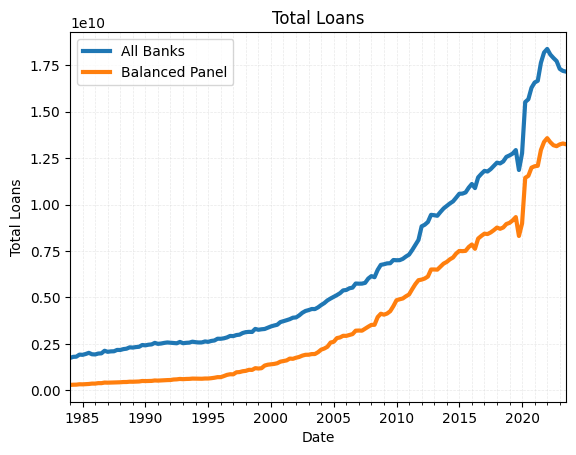

In [36]:
# sum 'Loans' by 'Date' and plot the time series:
df_rcon[df_rcon['Flag']==0].groupby('Date')['RCON2200'].sum().plot(linewidth=3)
balanced_rcon[balanced_rcon['Flag']==0].groupby('Date')['RCON2200'].sum().plot(linewidth=3)
plt.title('Total Loans')
plt.xlabel('Date')
plt.ylabel('Total Loans')
plt.legend(['All Banks', 'Balanced Panel'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5, color='lightgrey')
plt.show()

In [37]:
# export the balanced panel to a csv file:
balanced_rcon.to_csv(path+'/deposits_balanced_panel.csv', index=False)
df_rcon.to_csv(path+'/deposits_unbalanced.csv', index=False)

## Merging Securities

In [38]:
rcfd_securities_new = pd.read_csv(path+'/newer/rcfd_securities_new.csv')
rcfd_securities_new.rename(columns = {'RSSD9001':'idrssd', 'RSSD9999': 'date'}, inplace = True)
rcfd_securities_new['date'] = pd.to_datetime(rcfd_securities_new['date'], format='%Y-%m-%d')

rcon_securities_new = pd.read_csv(path+'/newer/rcon_securities_new.csv')
rcon_securities_new.rename(columns = {'RSSD9001':'idrssd', 'RSSD9999': 'date'}, inplace = True)
rcon_securities_new['date'] = pd.to_datetime(rcon_securities_new['date'], format='%Y-%m-%d')

rcon_securities_legacy = pd.read_csv(path+'/legacy/rcon_securities_legacy.csv')
rcon_securities_legacy.rename(columns = {'RSSD9001':'idrssd', 'RSSD9999': 'date'}, inplace = True)
rcon_securities_legacy['date'] = pd.to_datetime(rcon_securities_legacy['date'], format='%Y%m%d')

rcfd_securities_legacy = pd.read_csv(path+'/legacy/rcon_securities_legacy.csv')
rcfd_securities_legacy.rename(columns = {'RSSD9001':'idrssd', 'RSSD9999': 'date'}, inplace = True)
rcfd_securities_legacy['date'] = pd.to_datetime(rcfd_securities_legacy['date'], format='%Y%m%d')

In [39]:
# show me the dates in rcon_legacy where 'RCON2122' and 'RCON1400' are not NaN:
df_rcon = pd.merge(rcon_securities_legacy, 
                    rcon_securities_new,
                    on=['date', 'idrssd'], suffixes=('_legacy', '_new'), how='outer')

# drop 'total_securities':
df_rcon.drop('total_securities', axis=1, inplace=True)

In [40]:
# create the '_difference' columns for 1754, 1771, 1772, 1773:
df_rcon['1754_difference'] = df_rcon['RCON1754_new'] - df_rcon['RCON1754_legacy']
df_rcon['1771_difference'] = df_rcon['RCON1771_new'] - df_rcon['RCON1771_legacy']
df_rcon['1772_difference'] = df_rcon['RCON1772_new'] - df_rcon['RCON1772_legacy']
df_rcon['1773_difference'] = df_rcon['RCON1773_new'] - df_rcon['RCON1773_legacy']

In [41]:
# show df_rcon from 2001 to 2021:
df_rcon[(df_rcon['date']>=pd.to_datetime('2001-01-01')) & 
        (df_rcon['date']<=pd.to_datetime('2021-01-01'))][['date', 'idrssd', '1754_difference', '1771_difference',
                                                                            '1772_difference', '1773_difference']]

# create a 'Flag' that takes the value 1 if any of the differences is different from zero:
df_rcon['Flag'] = np.where((df_rcon['1754_difference']!=0) | (df_rcon['1771_difference']!=0) |
                           (df_rcon['1772_difference']!=0) | (df_rcon['1773_difference']!=0), 1, 0)

In [50]:
# create a 'total_securities' column summing up the four columns filling NaN with zeros:
df_rcon['total_securities'] = (df_rcon['RCON1754_new'] + df_rcon['RCON1771_new'] + 
                               df_rcon['RCON1772_new'] + df_rcon['RCON1773_new']).fillna(0)

In [58]:
# Step 1: Identify the total number of unique dates
total_dates = df_rcon['date'].nunique()

# Step 2: Count the number of unique dates per bank
bank_date_counts = df_rcon.groupby('idrssd')['date'].nunique()

# Step 3: Filter banks with observations for all dates
balanced_banks = bank_date_counts[bank_date_counts == total_dates].index

# Step 4: Save the list of IDRSSD
balanced_banks_list = balanced_banks.tolist()

In [64]:
securities_balanced = df_rcon[df_rcon['idrssd'].isin(balanced_banks_list)][['idrssd', 'date', 'total_securities']]
securities_balanced.rename(columns={'total_securities': 'Total Securities', 'idrssd': 'IDRSSD', 'date': 'Date'}, inplace=True)
securities_balanced.to_csv(path+'/securities_balanced_panel.csv', index=False)